In [1]:
import tensorflow as tf
import tensorflow_hub as hub

#GETTING DATA READY 

In [2]:
import pandas as pd
labels_csv=pd.read_csv("../input/dog-breed-identification/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<AxesSubplot:>

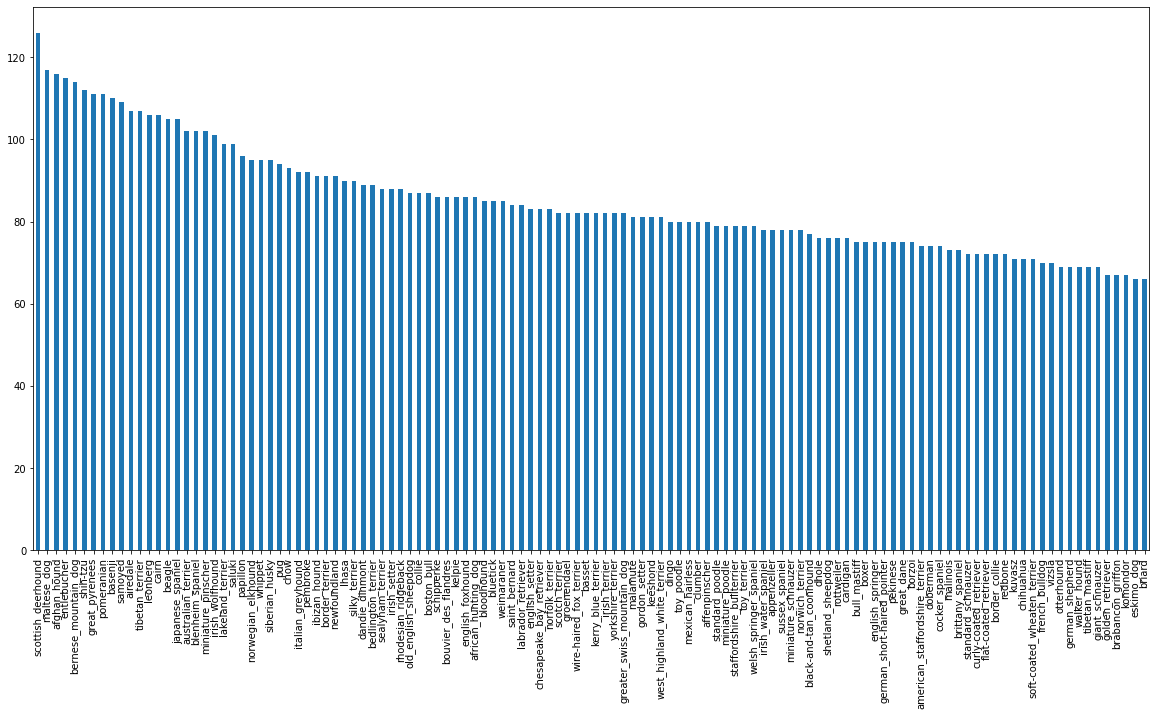

In [3]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

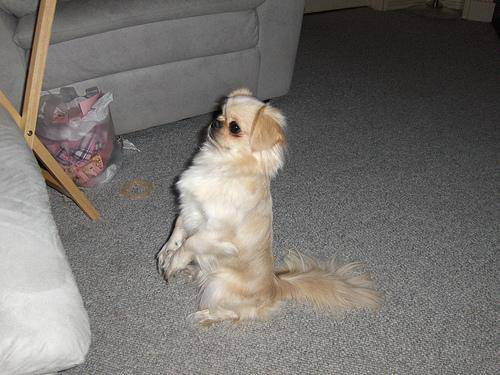

In [4]:
from IPython.display import Image
Image("../input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg")

In [5]:
filename=["../input/dog-breed-identification/train/"+ fname +".jpg" for fname in labels_csv['id']]


In [6]:
len(filename)

10222

In [7]:
filename[1]

'../input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

In [8]:
import os
len(os.listdir("../input/dog-breed-identification/train"))

10222

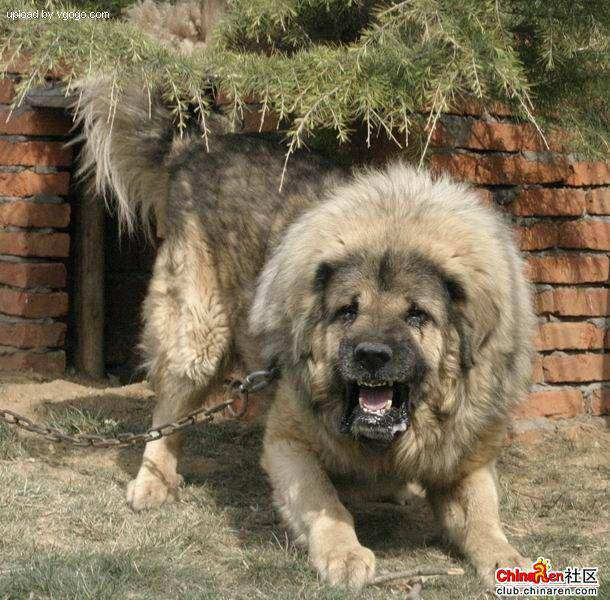

In [9]:
Image(filename[9000])

In [10]:
labels_csv.iloc[9000]['breed']

'tibetan_mastiff'

In [11]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

#OUR LABELS into BOOLEAN VALUES

In [12]:
import numpy as np
labels=np.array(labels_csv['breed'])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
if len(labels)==len(filename):
  print("yes")
else:
  print("no")

yes


In [14]:
unique_breeds=np.unique(labels)
boolean_values=[label==unique_breeds for label in labels]
boolean_values[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

#VALIDATION SPLIT

In [15]:
NUM_IMAGES=1000 #@param{type:"slider" ,min:1000,max:10000,step:1000}

In [16]:
X=filename
y=boolean_values
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=1)
len(y_valid)
X_train[0]

'../input/dog-breed-identification/train/0943d1d4677ab876b52468096baaa2ce.jpg'

#TURNING IMAGES INTO TESNORS

In [17]:
import matplotlib.pyplot as plt
image=plt.imread(filename[1])
image.shape

(375, 500, 3)

In [18]:
tf.constant(image)[:2]

2022-10-03 15:02:08.167014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[ 51,  34,  27],
        [ 55,  38,  30],
        [ 61,  42,  35],
        ...,
        [128,  92,  60],
        [ 78,  42,  10],
        [168, 132, 100]],

       [[ 62,  45,  37],
        [ 64,  45,  38],
        [ 63,  45,  35],
        ...,
        [115,  81,  53],
        [ 46,  12,   0],
        [ 73,  39,  11]]], dtype=uint8)>

In [19]:
def tensor1(fp):
  image=plt.imread(fp)
  image=tf.constant(image)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,(244,244))
  return image

#another moethod only using tensorflow
def tensor(fp):
  image=tf.io.read_file(fp) #or we can use plt.imread(fp)
  image=tf.image.decode_jpeg(image,3) #or we can use image=tf.constant(image)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,(224,224))
  return image


#BATCHES ARE REQUIRED

In [20]:
def get_tuple(image_path,label):
  image=tensor(image_path)
  return image,label

In [21]:
p=get_tuple(filename[100],y[100])
type(p)

tuple

#TURNING OUR DATA INTO BATCHES

In [22]:
BATCH_SIZE=32

def data_batches(X,y=None,batch_size=BATCH_SIZE,test_data=False,validation_data=False):
  if test_data:
    print("test_data")
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X)) #we use this unbatch the data
    data=data.map(tensor).batch(BATCH_SIZE)    # we use this to map and bacth data of batch_size=2
    return data
  elif validation_data:
    print("Validation_data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                            tf.constant(y)))
    data=data.map(get_tuple).batch(BATCH_SIZE)
    return data
  else:
    print("train_data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                            tf.constant(y)))
    data=data.shuffle(buffer_size=len(X))
    data=data.map(get_tuple).batch(BATCH_SIZE)
    return data
    

In [23]:
train_data=data_batches(X_train,y_train)
validation_data=data_batches(X_valid,y_valid,validation_data=True)

train_data
Validation_data


In [24]:
len(train_data)

25

In [25]:
train_data.element_spec,validation_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [26]:
train_images,train_labels=next(train_data.as_numpy_iterator())
train_images,train_labels

2022-10-03 15:02:09.029105: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(array([[[[0.99216706, 0.9890598 , 0.9733736 ],
          [0.9669195 , 0.9629979 , 0.94731164],
          [0.9618791 , 0.9579575 , 0.94227123],
          ...,
          [0.40750137, 0.46632493, 0.4415175 ],
          [0.36040762, 0.41471434, 0.4294554 ],
          [0.24438788, 0.29536828, 0.32674083]],
 
         [[0.9714405 , 0.967519  , 0.9518327 ],
          [0.96986806, 0.9659465 , 0.9502602 ],
          [0.99958146, 0.9995377 , 0.9838515 ],
          ...,
          [0.31009105, 0.3532283 , 0.36124653],
          [0.27927843, 0.33026546, 0.35377494],
          [0.31994295, 0.37094015, 0.39441916]],
 
         [[0.97432363, 0.97040206, 0.9547158 ],
          [0.94851214, 0.94459057, 0.9289043 ],
          [0.9250934 , 0.92117184, 0.9054856 ],
          ...,
          [0.27990776, 0.31767038, 0.34926176],
          [0.24680506, 0.3006601 , 0.31474966],
          [0.24332812, 0.2974697 , 0.30945197]],
 
         ...,
 
         [[0.4645665 , 0.5469194 , 0.65280175],
          [0.49711

In [27]:
validation_images,validation_labels=next(validation_data.as_numpy_iterator())

In [28]:
import matplotlib.pyplot as plt
def visualize(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

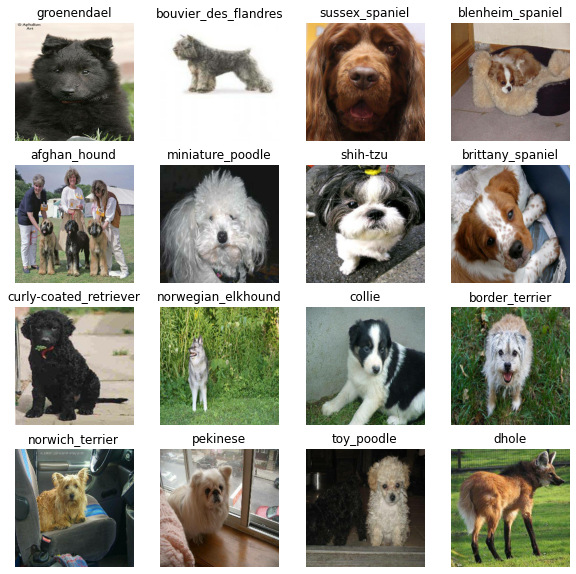

In [29]:
visualize(validation_images,validation_labels)

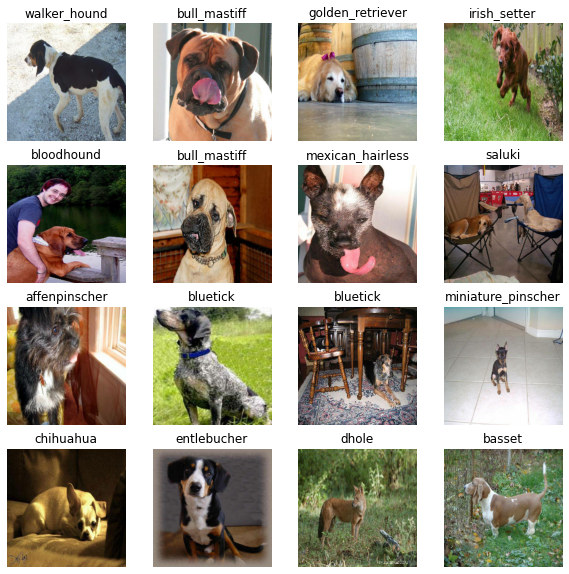

In [30]:
visualize(train_images,train_labels)

#BULDING A MODEL

In [31]:
INPUT_SIZE=[None,224,224,3]
OUTPUT_SIZE=len(unique_breeds)
model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
def create_model(INPUT_SIZE=[None,224,224,3],OUTPUT_SIZE=len(unique_breeds),model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"):

  #setting up the layers
  model=tf.keras.Sequential([
      hub.KerasLayer(model_url),
      tf.keras.layers.Dense(units=OUTPUT_SIZE,
                            activation='softmax')])
  
  #compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  #bulid the model
  model.build(INPUT_SIZE)

  return model

In [32]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


CREATING CALL BACKS

In [33]:
%load_ext tensorboard

In [34]:
import datetime
 
# we tensorboard to check and save the progress

def call_Teansorboard():
  #create a log folder in mydrive to store logs
  log_dir=os.path.join("./logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [35]:
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=3)

In [36]:
epochs = 100 #@param {type:"slider", min:10, max:100, step:10}

In [37]:
def train_model():
  #create a model
  model=create_model()

  #tensorboard
  tensorboard=call_Teansorboard()

  #fit model
  model.fit(x=train_data,
            epochs=epochs,
            validation_data=validation_data,
            validation_freq=1,
            callbacks=[tensorboard,earlystopping])
  return model

In [38]:
model=train_model()

2022-10-03 15:02:18.513301: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-03 15:02:18.513536: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-03 15:02:18.514561: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 1/25 [>.............................] - ETA: 2:11 - loss: 6.1000 - accuracy: 0.0000e+00

2022-10-03 15:02:24.797492: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-03 15:02:24.797727: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/25 [=>............................] - ETA: 29s - loss: 5.9095 - accuracy: 0.0000e+00 

2022-10-03 15:02:25.379536: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-03 15:02:25.395223: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-03 15:02:25.418438: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20221003-150218/train/plugins/profile/2022_10_03_15_02_25

2022-10-03 15:02:25.423895: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/20221003-150218/train/plugins/profile/2022_10_03_15_02_25/8568eb3168f2.trace.json.gz
2022-10-03 15:02:25.460368: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/20221003-150218/train/plugins/profile/2022_10_03_15_02_25

2022-10-03 15:02:25.464316: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/20221003-150218/train/plugins/profile/2022_10_03_15

25/25 [==============================] - 23s 737ms/step - loss: 4.6845 - accuracy: 0.0862 - val_loss: 3.3899 - val_accuracy: 0.2450
Epoch 2/100
25/25 [==============================] - 15s 603ms/step - loss: 1.6762 - accuracy: 0.6750 - val_loss: 2.0386 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 15s 593ms/step - loss: 0.5694 - accuracy: 0.9400 - val_loss: 1.5239 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 15s 596ms/step - loss: 0.2499 - accuracy: 0.9887 - val_loss: 1.3382 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 15s 600ms/step - loss: 0.1412 - accuracy: 1.0000 - val_loss: 1.2705 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 15s 618ms/step - loss: 0.0974 - accuracy: 1.0000 - val_loss: 1.2205 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================] - 15s 592ms/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 1.1888 - val_accuracy: 0.6600
Epoc

EVALUATING A MODEL

In [39]:
%tensorboard --logdir drive/MyDrive/logs

PREDICTIONS

In [40]:
predictions=model.predict(validation_data,verbose=1)
len(predictions)# ---> these are probability of unique breeds

7/7 [==============================] - 4s 407ms/step


200

In [41]:
def get_labels_predicted(prediction):
  li=[]
  for i in range(len(prediction)):
    li.append(unique_breeds[prediction[i].argmax()])
  return li

def get_label_predicted(predict):
  return unique_breeds[predict.argmax()]



def unbatch(data):
  data_images=[]
  data_labels=[]
  for images,labels in data.unbatch().as_numpy_iterator():
    data_images.append(images)
    data_labels.append(labels)
  return data_images,get_labels_predicted(data_labels)

In [42]:
valid_images,valid_labels=unbatch(validation_data)
len(valid_images)

200

PLOTTING THE PREDICTIONS

In [43]:
def plot(predic,val_labels,val_images,n=1):
  plt.imshow(val_images[n])
  plt.xticks([])
  plt.yticks([])

  if get_label_predicted(predic[n])==val_labels[n]:
    color='green'
  else:
    color='red'
  
  plt.axis('off')
  plt.title("{} {:2.0f}% {}".format(get_label_predicted(predic[n]),max(predic[n])*100,val_labels[n]),color=color)


def predictions_wrong_count(valid_labels,predictions):
  count=0
  for i in range(len(predictions)):
    if valid_labels[i]==get_label_predicted(predictions[i]):
      count+=1
  return count



def top_10_possibilities_plot(predic,val_labels,n=1):

  top_10_possibilities_indexes=predic[n].argsort()[-10:][::-1]

  top_10_possibilities_values=predic[n][top_10_possibilities_indexes]

  top_10_possibilities_labels=unique_breeds[top_10_possibilities_indexes]

  top_plot=plt.bar(np.arange(len(top_10_possibilities_labels)),top_10_possibilities_values,color='grey')

  plt.xticks(np.arange(len(top_10_possibilities_labels)),top_10_possibilities_labels,rotation='vertical')

  if np.isin(val_labels[n],top_10_possibilities_labels):
    top_plot[np.argmax(top_10_possibilities_labels==val_labels[n])].set_color('green')
  else:
    pass
  

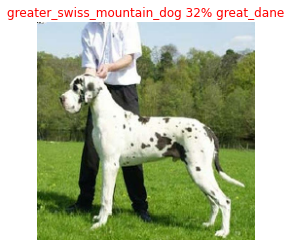

In [44]:
plot(predictions,valid_labels,valid_images,191)

In [45]:
predictions_wrong_count(valid_labels,predictions)

137

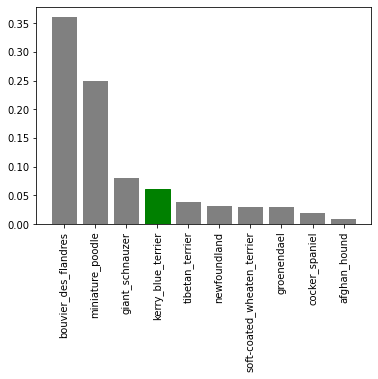

In [46]:
top_10_possibilities_plot(predictions,valid_labels,131)

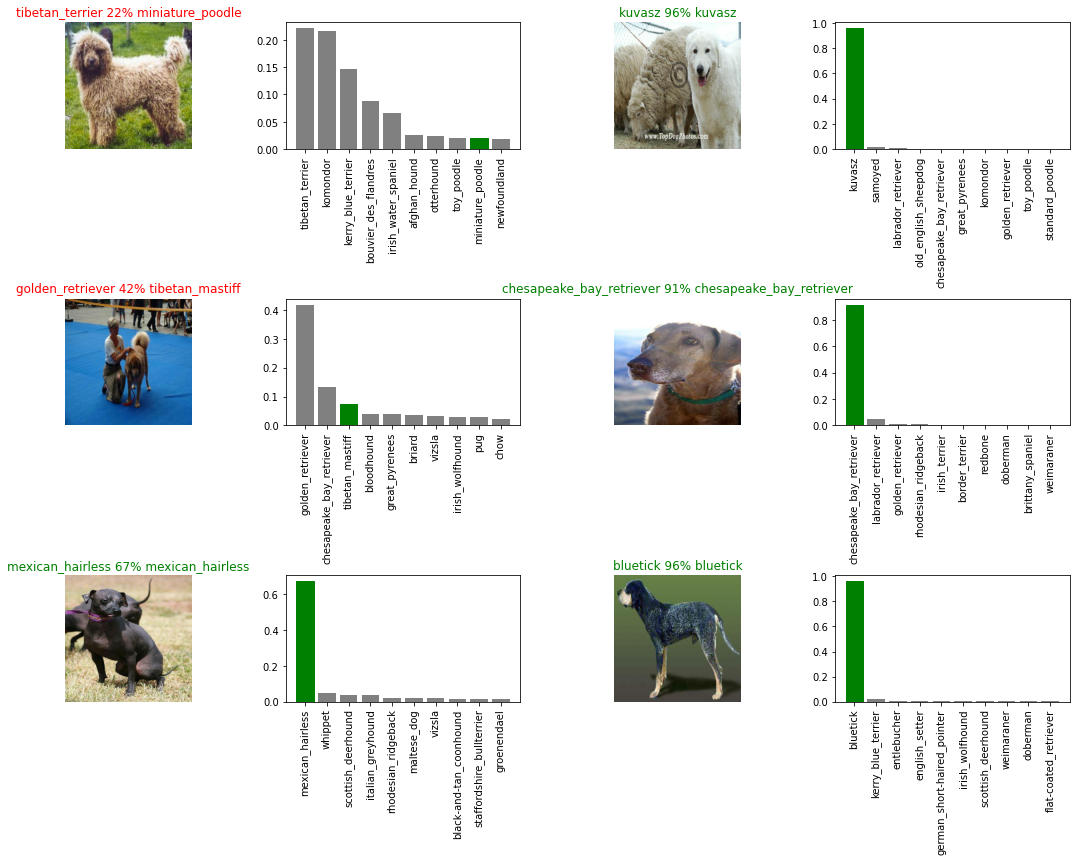

In [47]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(7.5*num_cols, 4*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot(predictions,
            valid_labels,
            valid_images,
            i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  top_10_possibilities_plot(predictions,
                 valid_labels,
                 i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

LOADING AND SAVING THE MODEL

In [48]:
def save_model(model, suffix=None):
  # Create a model directory pathname with current time
  modeldir = os.path.join("./",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [49]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [50]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: ./20221003-15081664809715-1000-images-mobilenetv2-Adam.h5...


'./20221003-15081664809715-1000-images-mobilenetv2-Adam.h5'

In [51]:
loaded_1000_image_model = load_model('./20221003-14531664808815-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: ./20221003-14531664808815-1000-images-mobilenetv2-Adam.h5


OSError: SavedModel file does not exist at: ./20221003-14531664808815-1000-images-mobilenetv2-Adam.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
model.evaluate(validation_data)

In [ ]:
loaded_1000_image_model.evaluate(validation_data)

BULIDING MODEL ON TOTAL DATA

In [ ]:
final_train_data=data_batches(X,y)
len(final_train_data) #--> no.of bacthes  each batch contain 32 entries of data

In [ ]:
final_model=create_model()
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                               patience=3)

In [ ]:
save_model(final_model, suffix="final-image-set-mobilenetv2-Adam")

TEST DATA

In [ ]:
import os
test_path = "../input/dog-breed-identification/test/"
test_file_name=[test_path+fname for fname in os.listdir(test_path)]
test_file_name[:10]

In [ ]:
len(test_file_name)

In [ ]:
test_data=data_batches(test_file_name,test_data=True)
test_data

PREDICTING FOR TEST_DATA

In [ ]:
final_prediction1=final_model.predict(test_data,verbose=1)

In [ ]:
final_prediction1[:10]

In [ ]:
submission_csv=pd.DataFrame(columns=['id']+list(unique_breeds))

In [ ]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [ ]:
submission_csv['id']=test_ids

In [ ]:
submission_csv[list(unique_breeds)]=final_prediction1

In [ ]:
submission_csv.head()

In [ ]:
len(submission_csv)

In [ ]:
submission_csv.to_csv("./submission_csv.csv",index=False)